In [1]:
import sys 
sys.path.append("..") 
from utils import config
from utils.seq2seq.batcher import *
from utils.seq2seq.train_util import *
import argparse


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

parser = argparse.ArgumentParser()
parser.add_argument('--key_attention', type=bool, default=False, help = 'True/False')
parser.add_argument('--intra_encoder', type=bool, default=False, help = 'True/False')
parser.add_argument('--intra_decoder', type=bool, default=False, help = 'True/False')
parser.add_argument('--copy', type=bool, default=True, help = 'True/False') # for transformer

parser.add_argument('--model_type', type=str, default='seq2seq', choices=['seq2seq', 'transformer'])
parser.add_argument('--train_rl', type=bool, default=False, help = 'True/False')
parser.add_argument('--keywords', type=str, default='POS_keys', 
                    help = 'POS_keys / DEP_keys / Noun_adj_keys / TextRank_keys')

parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--rand_unif_init_mag', type=float, default=0.02)
parser.add_argument('--trunc_norm_init_std', type=float, default=0.001)
parser.add_argument('--mle_weight', type=float, default=1.0)
parser.add_argument('--gound_truth_prob', type=float, default=0.1)

parser.add_argument('--max_enc_steps', type=int, default=1000)
parser.add_argument('--max_dec_steps', type=int, default=50)
parser.add_argument('--min_dec_steps', type=int, default=8)
parser.add_argument('--max_epochs', type=int, default=10)
parser.add_argument('--vocab_size', type=int, default=50000)
parser.add_argument('--beam_size', type=int, default=16)
parser.add_argument('--batch_size', type=int, default=1)

parser.add_argument('--hidden_dim', type=int, default=512)
parser.add_argument('--emb_dim', type=int, default=300)
parser.add_argument('--gradient_accum', type=int, default=1)

parser.add_argument('--word_emb_type', type=str, default='word2Vec', help='word2Vec/glove/FastText')
parser.add_argument('--pre_train_emb', type=bool, default=True, help = 'True/False') # 若pre_train_emb為false, 則emb type為NoPretrain

opt = parser.parse_args(args=[])
config = re_config(opt)


# Load Model

In [2]:
load_model_path = 'PG-less.tar'  


import torch as T

T.backends.cudnn.benchmark = True 
checkpoint = T.load(load_model_path)
vocab = checkpoint['vocab']
print(load_model_path)

from create_model.pointer_less import Model 

model = Model(pre_train_emb=config.pre_train_emb, 
              word_emb_type = config.word_emb_type, 
              vocab = vocab)

model = model.cuda()
model.load_state_dict(checkpoint['model'])
model.eval()

PG-less.tar


I0621 01:00:44.575450 140532463683392 file_utils.py:35] PyTorch version 1.4.0 available.
/home/eagleuser/.conda/envs/Leyan/lib/python3.6/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
I0621 01:00:45.857597 140532463683392 utils_any2vec.py:341] loading projection weights from /home/eagleuser/Users/leyan//Train-Data/Mix6_mainCat_Ekphrasis/Embedding/word2Vec/word2Vec.300d.txt


/home/eagleuser/Users/leyan//Train-Data/Mix6_mainCat_Ekphrasis/Embedding/word2Vec/word2Vec.300d.txt


I0621 01:00:54.484159 140532463683392 utils_any2vec.py:405] loaded (49385, 300) matrix from /home/eagleuser/Users/leyan//Train-Data/Mix6_mainCat_Ekphrasis/Embedding/word2Vec/word2Vec.300d.txt


Model(
  (encoder): Encoder(
    (lstm): LSTM(300, 512, batch_first=True, dropout=0.2, bidirectional=True)
    (reduce_h): Linear(in_features=1024, out_features=512, bias=True)
    (reduce_c): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (enc_attention): MultiHeadedAttention(
      (linears): ModuleList(
        (0): Linear(in_features=1024, out_features=1024, bias=True)
        (1): Linear(in_features=1024, out_features=1024, bias=True)
        (2): Linear(in_features=1024, out_features=1024, bias=True)
        (3): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (dec_attention): decoder_attention()
    (x_context): Linear(in_features=1324, out_features=300, bias=True)
    (x_key_context): Linear(in_features=1624, out_features=300, bias=True)
    (lstm): LSTMCell(300, 512)
    (p_gen_linear): Linear(in_features=2860, out_features=1, bias=True)
    (p_gen_dropout): Dropout(p=0

In [3]:
from utils.seq2seq.batcher import Example, Batch
import matplotlib.pyplot as plt

config.batch_size = 1
config.gound_truth_prob = 0.1

data = {'review_ID':'',
        'review':'this mongoose flat tire bike joke pretty easy assemble and gorgeous but catch tough the upper thigh area when you ride it . now been awhile since rode bike go take some get use too . never the less love this bike and make anyone look cool ride it .',
        'summary':'it is pretty easy to assemble and it is gorgeous but there is',
        'POS_keys': "['good', 'sound', 'static', 'terrible', 'listen', 'book', 'audio', 'speaker', 'recommend']",
       "percent_lcs": '40.0'}

# data = {'review':'have use variety laser target and would have say these are the most practical most versatile and most economical target out there . they are very well build and unlike one other reviewer state they are indeed design free stand you use the well think out fold away wall hang clip . prefer the round design emulate most the target shoot being steel plate and regulation pistol target . the best thing about their round nondescript appearance that they rather resemble smoke detector allow hang them around the house without look like the gun fanatic that advertising that have gun . may fact paint the red portion beige match house and trim . the target small and the bullseye indeed the small sub one inch white dot the center . can figure out how attach picture will post pic the target next laser lyte target and next shield for size comparison . first think the bull eye was cruel joke truly tiny yard but can tell you that this target will test your fundamental and indeed make you much better shot . the first week was frustrate find nigh impossible hit dead center require activate but truth tell just need hone skill . after about month now can regularly score out hit yard . another thing like about this target that have not have activate from light the home the fairly bright ambient sunlight which experience with few other laser activate target . had set laser lyte can that were set the darkest corner the house activate their own and run down their battery . speak battery had the same battery these for month and they are still go strong . never shut these off and shoot then least 700 time week . the only criticism these that the off switch locate under the battery cover which pain but the great battery life more than compensate for the inconvenience . rarely give product star but was compel due the great customer service receive from the company . the first target receive was damage and within day contact the seller receive brand new target . did not even have time repack the broken one send back . now have these target and will buy some more set home competition range for friend and family . did not receive any discount for this hate those post buy this will save you thousand you shoot much and support company that back product .',
#         'summary':'best bang for the buck great laser target',
#         'POS_keys': "['economical', 'target', 'well', 'free', 'stand', 'use', 'round', 'design']",
#        "percent_lcs": '40.0'}

ex = Example(config, vocab, data)
b = Batch([ex])

b.enc_pad_mask

enc_batch, enc_padding_mask, enc_lens, enc_batch_extend_vocab, extra_zeros, coverage, ct_e, enc_key_batch, enc_key_mask, enc_key_lens= \
                get_input_from_batch(b, config, batch_first = True)
dec_batch, dec_padding_mask, dec_lens, max_dec_len, target_batch = \
        get_output_from_batch(b, config, batch_first = True)

max_enc_len = max(T.max(enc_lens,dim=0)).tolist()[0]    

# plot_attention

In [4]:
def plot_enc_attention(idx, data, X_label=None, Y_label=None):
    '''
    Plot the attention model heatmap
    Args:
      data: attn_matrix with shape [ty, tx], cutted before 'PAD'
      X_label: list of size tx, encoder tags
      Y_label: list of size ty, decoder tags
    '''
    fig, ax = plt.subplots(figsize=(20, 8)) # set figure size
    #   heatmap = ax.pcolor(data, cmap=plt.cm.Blues, alpha=0.9)
    heatmap = ax.pcolor(data, cmap='viridis', alpha=0.9)
#     heatmap = ax.pcolor(data, cmap='hot', alpha=0.9)
    plt.colorbar(heatmap)
  
  # Set axis labels
    if X_label != None and Y_label != None:
        X_label = [x_label for x_label in X_label]
        Y_label = [y_label for y_label in Y_label]

        xticks = range(0,len(X_label))
        ax.set_xticks(xticks, minor=False) # major ticks
        ax.set_xticklabels(X_label, minor = False, rotation=90)   # labels should be 'unicode'
        plt.xlabel('Review words')
        
        yticks = range(0,len(Y_label))
        ax.set_yticks(yticks, minor=False)
        ax.set_yticklabels(Y_label, minor = False)   # labels should be 'unicode'
        plt.ylabel('Summary words')
        plt.title('Encoder %s-Head Attention' %(idx))

        ax.grid(True)      

In [5]:
max_enc_len

50

In [6]:
decode = []
decode_2 = []
embed_words = []
with T.autograd.no_grad():
    enc_batch_ = model.embeds(enc_batch)  # Get embeddings for encoder input    
    enc_key_batch = model.embeds(enc_key_batch)  # Get key embeddings for encoder input
    enc_out, enc_hidden = model.encoder(enc_batch_, enc_lens, max_enc_len)

    s_t = (enc_hidden[0], enc_hidden[1])  # Decoder hidden states
    x_t = get_cuda(T.LongTensor(len(enc_out)).fill_(START))  # Input to the decoder
    prev_s = None  # Used for intra-decoder attention (section 2.2 in https://arxiv.org/pdf/1705.04304.pdf)
    sum_temporal_srcs = None  # Used for intra-temporal attention (section 2.1 in https://arxiv.org/pdf/1705.04304.pdf)
    weight = None
    dec_weight = []  

    for t in range(min(max_dec_len, config.max_dec_steps)):
        use_gound_truth = get_cuda((T.rand(len(enc_out)) > config.gound_truth_prob)).long()  # Probabilities indicating whether to use ground truth labels instead of previous decoded tokens
        x_t = use_gound_truth * dec_batch[:, t] + (1 - use_gound_truth) * x_t  # Select decoder input based on use_ground_truth probabilities
        embed_words.append(x_t.item())
        x_t = model.embeds(x_t)  
        final_dist, s_t, ct_e, sum_temporal_srcs, prev_s, enc_attn, dec_attn = model.decoder(x_t, s_t, enc_out, enc_padding_mask,
                                                                                  ct_e, extra_zeros,
                                                                                  enc_batch_extend_vocab,
                                                                                  sum_temporal_srcs, prev_s, enc_key_batch, enc_key_mask)

       
        x_t = T.max(final_dist, dim=1)[1]  # Sample words from final distribution which can be used as input in next time step

        
        if t == 0: 
            weight = enc_attn; 
        else: 
            weight = T.cat((weight, enc_attn), 0)  
        
        dec_weight.append(dec_attn) 
        
        decode.append(x_t.item())
        # x軸是tgt words
        # y軸是src words
    # print(weight.shape)
print(decode)

dec_words = [vocab.id2word(d) for d in decode]
dec_words = " ".join(dec_words) 
data['dec_words'] = dec_words
print('dec_words',dec_words)

# embed_words = embed_words[1:]
# print(embed_words)
embed_words = [vocab.id2word(d) for d in embed_words]
embed_words = " ".join(embed_words) 
data['embed_words'] = embed_words
print('embed_words',embed_words)
print('summary',data['summary'])

[15, 9979, 9, 124, 1112, 1112, 3, 2819, 3, 3, 3, 3, 3, 3]
dec_words this mongoose a easy assemble assemble [STOP] gorgeous [STOP] [STOP] [STOP] [STOP] [STOP] [STOP]
embed_words [START] this is pretty easy to assemble and it is [STOP] but there is
summary it is pretty easy to assemble and it is gorgeous but there is


# Encoder Multi-Head Attention

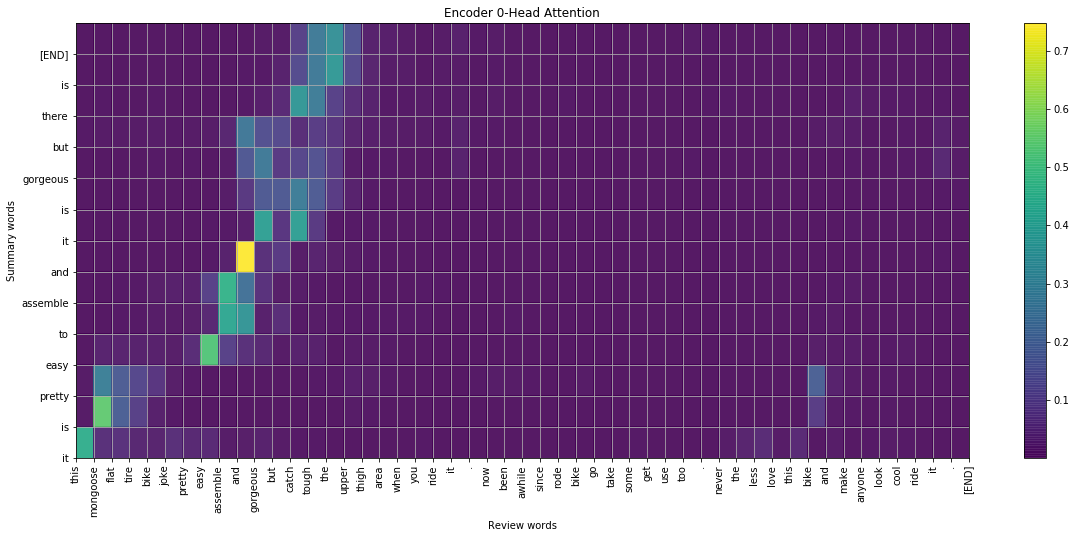

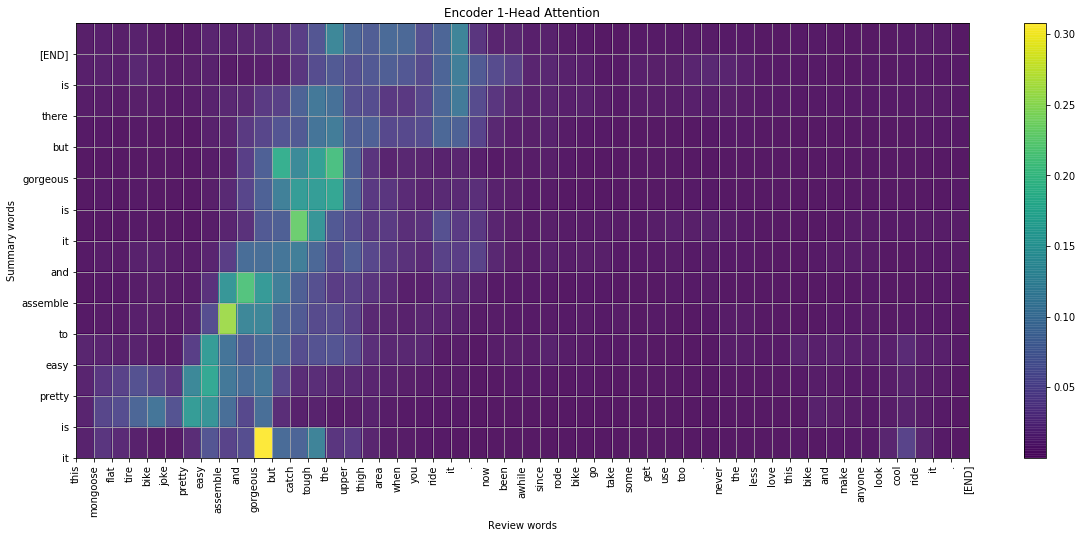

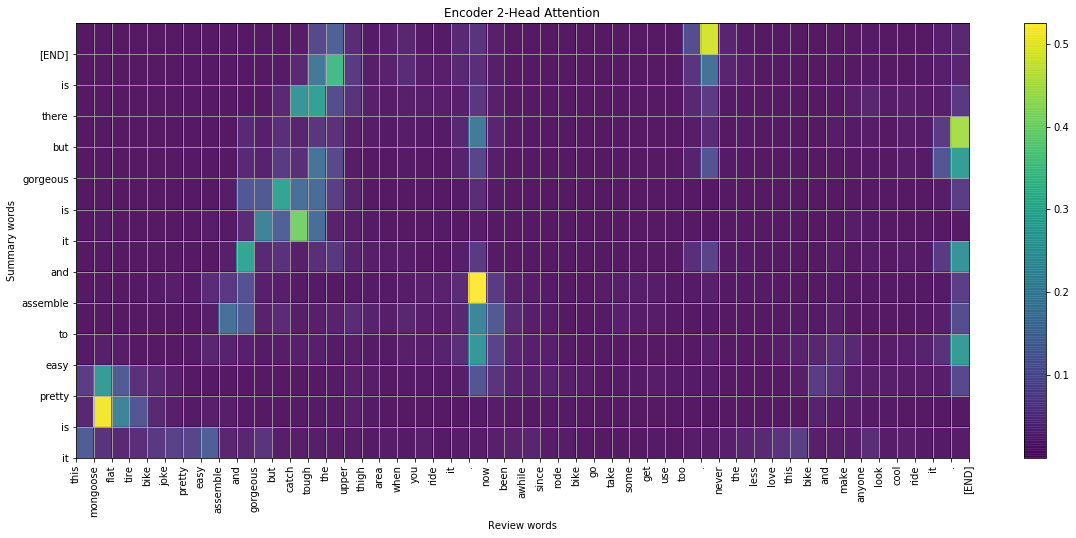

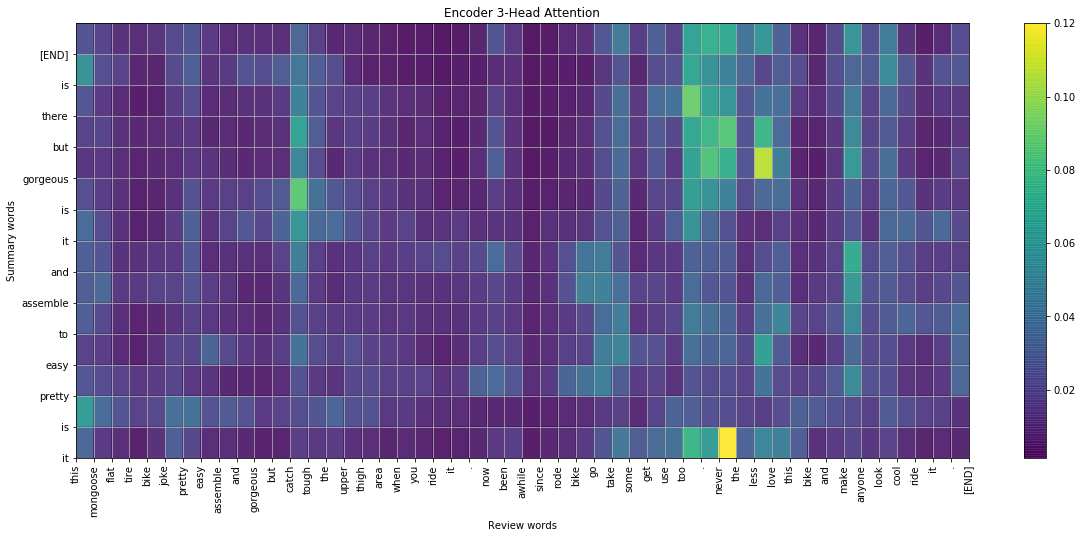

In [7]:
def plot_Multi_Head(weight):
    l = len(weight[0])
    for i in range(l):
        plot_enc_attention(i, weight[:,i,:].cpu().data, X_label=data['review'].split() + ['[END]'], Y_label= data['summary'].split() + ['[END]'])

plot_Multi_Head(weight)    

In [8]:
dec_weight[1:]

[None, None, None, None, None, None, None, None, None, None, None, None, None]